best results so far:

learning_rate = 0.0001
epochs_ini = 9000
batch_size = 700
layer_list=[10,15,10]

In [1]:
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np


from tensorflow.keras.layers import LSTM

H:\Users\Gwydion\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
H:\Users\Gwydion\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
H:\Users\Gwydion\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
H:\Users\Gwydion\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub

In [2]:
df_spectra=pd.read_csv("spectrum_energy_intensity2.csv",index_col=[0])
df_spectra.head(-50)

,Energy,Intensity,k6a1,k6a2,k11,k12,k9a1,k9a2
0,0.874,0.019935,0.25,0.25,0.25,0.25,0.25,0.25
1,0.213,0.060488,0.25,0.25,0.25,0.25,0.25,0.50
2,0.866,0.020153,0.25,0.25,0.25,0.25,0.25,0.75
3,0.867,0.019641,0.25,0.25,0.25,0.25,0.50,0.25
4,0.220,0.060471,0.25,0.25,0.25,0.25,0.50,0.50
...,...,...,...,...,...,...,...,...
674,0.868,0.021991,0.75,0.75,0.25,0.75,0.75,0.75
675,0.865,0.021101,0.75,0.75,0.50,0.25,0.25,0.25
676,0.213,0.060723,0.75,0.75,0.50,0.25,0.25,0.50
677,0.868,0.019078,0.75,0.75,0.50,0.25,0.25,0.75


In [3]:
numpy_input=df_spectra[["k6a1","k6a2","k11","k12","k9a1","k9a2"]].to_numpy()
numpy_energy_intensity=df_spectra[["Energy","Intensity"]].to_numpy()


df_complete=pd.DataFrame(numpy_energy_intensity)
df_training=df_spectra.sample(frac=0.8,random_state=20)
df_testing=df_spectra.drop(df_training.index)

In [4]:
feature_columns_A = []

k6a1 = tf.feature_column.numeric_column("k6a1")
feature_columns_A.append(k6a1)

k6a2 = tf.feature_column.numeric_column("k6a2")
feature_columns_A.append(k6a2)

k11 = tf.feature_column.numeric_column("k11")
feature_columns_A.append(k11)

k12 = tf.feature_column.numeric_column("k12")
feature_columns_A.append(k12)

k9a1 = tf.feature_column.numeric_column("k9a1")
feature_columns_A.append(k9a1)

k9a2 = tf.feature_column.numeric_column("k9a2")
feature_columns_A.append(k9a2)

my_feature_layer_A = tf.keras.layers.DenseFeatures(feature_columns_A)


In [5]:
#define the plotting function.

def plot_the_loss_curve(epochs, mse,mse_test=0):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    if(mse_test!=0):
        plt.plot(epochs,mse_test)
    plt.legend()
    plt.ylim([mse.min()*0.95, mse.max() * 1.03])
    plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [6]:
def create_model(my_learning_rate, my_feature_layer,layer_list=[10,12],regulations=0.04):
    """Create and compile a regression model."""
    model = tf.keras.models.Sequential()
    # Add the layer containing the feature columns to the model.
    model.add(my_feature_layer)

    # Describe the topography of the model by calling the tf.keras.layers.Dense
    # method once for each layer. We've specified the following arguments:
    #   * units specifies the number of nodes in this layer.
    #   * activation specifies the activation function (Rectified Linear Unit).
    #   * name is just a string that can be useful when debugging.

    # Define the first hidden layer with 10 nodes.   
    for n in layer_list:
        print(n)
        model.add(tf.keras.layers.Dense(units=n, activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(regulations),name='Hidden'+str(n)))
                
   
   

    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=1,  
                                    name='Output'))                              
  
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])
    return model



In [7]:
def train_model(model, dataset, epochs, label_name,
                batch_size=None):
    """Train the model by feeding it data."""

    # Split the dataset into features and label.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch
  
    # To track the progression of training, gather a snapshot
    # of the model's mean squared error at each epoch. 
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse

In [8]:
# The following variables are the hyperparameters.
learning_rate = 0.0001
epochs_ini = 9000
batch_size = 700

# Specify the label
label_name = "Energy"

#try different things:

my_model = create_model(learning_rate, my_feature_layer_A,layer_list=[10,15,10],regulations=0)

epochs, mse = train_model(my_model, df_training, epochs_ini, 
                          label_name, batch_size)



10
15
10
Epoch 1/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.3356 - mean_squared_error: 0.3356
Epoch 2/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.3346 - mean_squared_error: 0.3346
Epoch 3/9000
1/1 [==============================] - 0s 0s/step - loss: 0.3335 - mean_squared_error: 0.3335
Epoch 4/9000
1/1 [==============================] - 0s 0s/step - loss: 0.3324 - mean_squared_error: 0.3324
Epoch 5/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.3314 - mean_squared_error: 0.3314
Epoch 6/9000
1/1 [==============================] - 0s 0s/step - loss: 0.3303 - mean_squared_error: 0.3303
Epoch 7/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.3293 - mean_squared_error: 0.3293
Epoch 8/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.3282 - mean_squared_error: 0.3282
Epoch 9/9000
1/1 [==============================] - 0s 0s/step - loss: 0.3272 - mean_squared_error: 0.3272
Epoch 10/9000


1/1 [==============================] - 0s 1ms/step - loss: 0.2656 - mean_squared_error: 0.2656
Epoch 77/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.2647 - mean_squared_error: 0.2647
Epoch 78/9000
1/1 [==============================] - 0s 0s/step - loss: 0.2639 - mean_squared_error: 0.2639
Epoch 79/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.2630 - mean_squared_error: 0.2630
Epoch 80/9000
1/1 [==============================] - 0s 0s/step - loss: 0.2621 - mean_squared_error: 0.2621
Epoch 81/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.2612 - mean_squared_error: 0.2612
Epoch 82/9000
1/1 [==============================] - 0s 0s/step - loss: 0.2604 - mean_squared_error: 0.2604
Epoch 83/9000
1/1 [==============================] - 0s 0s/step - loss: 0.2595 - mean_squared_error: 0.2595
Epoch 84/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.2586 - mean_squared_error: 0.2586
Epoch 85/9000
1/1 [==================

1/1 [==============================] - 0s 0s/step - loss: 0.2012 - mean_squared_error: 0.2012
Epoch 151/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.2003 - mean_squared_error: 0.2003
Epoch 152/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1995 - mean_squared_error: 0.1995
Epoch 153/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1987 - mean_squared_error: 0.1987
Epoch 154/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1979 - mean_squared_error: 0.1979
Epoch 155/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1971 - mean_squared_error: 0.1971
Epoch 156/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1963 - mean_squared_error: 0.1963
Epoch 157/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1955 - mean_squared_error: 0.1955
Epoch 158/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1947 - mean_squared_error: 0.1947
Epoch 159/9000
1/1 [==========

1/1 [==============================] - 0s 1ms/step - loss: 0.1504 - mean_squared_error: 0.1504
Epoch 225/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1498 - mean_squared_error: 0.1498
Epoch 226/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1493 - mean_squared_error: 0.1493
Epoch 227/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1488 - mean_squared_error: 0.1488
Epoch 228/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1483 - mean_squared_error: 0.1483
Epoch 229/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1479 - mean_squared_error: 0.1479
Epoch 230/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1474 - mean_squared_error: 0.1474
Epoch 231/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1469 - mean_squared_error: 0.1469
Epoch 232/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1464 - mean_squared_error: 0.1464
Epoch 233/9000
1/1 [======

1/1 [==============================] - 0s 1ms/step - loss: 0.1246 - mean_squared_error: 0.1246
Epoch 299/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1244 - mean_squared_error: 0.1244
Epoch 300/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1242 - mean_squared_error: 0.1242
Epoch 301/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1240 - mean_squared_error: 0.1240
Epoch 302/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1238 - mean_squared_error: 0.1238
Epoch 303/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1236 - mean_squared_error: 0.1236
Epoch 304/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1235 - mean_squared_error: 0.1235
Epoch 305/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1233 - mean_squared_error: 0.1233
Epoch 306/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1231 - mean_squared_error: 0.1231
Epoch 307/9000
1/1 [=========

1/1 [==============================] - 0s 0s/step - loss: 0.1157 - mean_squared_error: 0.1157
Epoch 373/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1156 - mean_squared_error: 0.1156
Epoch 374/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1155 - mean_squared_error: 0.1155
Epoch 375/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1155 - mean_squared_error: 0.1155
Epoch 376/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1154 - mean_squared_error: 0.1154
Epoch 377/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1153 - mean_squared_error: 0.1153
Epoch 378/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1153 - mean_squared_error: 0.1153
Epoch 379/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1152 - mean_squared_error: 0.1152
Epoch 380/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1151 - mean_squared_error: 0.1151
Epoch 381/9000
1/1 [===========

1/1 [==============================] - 0s 1ms/step - loss: 0.1117 - mean_squared_error: 0.1117
Epoch 447/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1117 - mean_squared_error: 0.1117
Epoch 448/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1116 - mean_squared_error: 0.1116
Epoch 449/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1116 - mean_squared_error: 0.1116
Epoch 450/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1115 - mean_squared_error: 0.1115
Epoch 451/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1115 - mean_squared_error: 0.1115
Epoch 452/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1114 - mean_squared_error: 0.1114
Epoch 453/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1114 - mean_squared_error: 0.1114
Epoch 454/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1113 - mean_squared_error: 0.1113
Epoch 455/9000
1/1 [======

1/1 [==============================] - 0s 1ms/step - loss: 0.1092 - mean_squared_error: 0.1092
Epoch 521/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1092 - mean_squared_error: 0.1092
Epoch 522/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1091 - mean_squared_error: 0.1091
Epoch 523/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1091 - mean_squared_error: 0.1091
Epoch 524/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1091 - mean_squared_error: 0.1091
Epoch 525/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1091 - mean_squared_error: 0.1091
Epoch 526/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1091 - mean_squared_error: 0.1091
Epoch 527/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1090 - mean_squared_error: 0.1090
Epoch 528/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1090 - mean_squared_error: 0.1090
Epoch 529/9000
1/1 [========

1/1 [==============================] - 0s 0s/step - loss: 0.1077 - mean_squared_error: 0.1077
Epoch 595/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1077 - mean_squared_error: 0.1077
Epoch 596/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1077 - mean_squared_error: 0.1077
Epoch 597/9000
1/1 [==============================] - 0s 987us/step - loss: 0.1076 - mean_squared_error: 0.1076
Epoch 598/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1076 - mean_squared_error: 0.1076
Epoch 599/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1076 - mean_squared_error: 0.1076
Epoch 600/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1076 - mean_squared_error: 0.1076
Epoch 601/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1076 - mean_squared_error: 0.1076
Epoch 602/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1076 - mean_squared_error: 0.1076
Epoch 603/9000
1/1 [========

1/1 [==============================] - 0s 1ms/step - loss: 0.1067 - mean_squared_error: 0.1067
Epoch 669/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1067 - mean_squared_error: 0.1067
Epoch 670/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1067 - mean_squared_error: 0.1067
Epoch 671/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1067 - mean_squared_error: 0.1067
Epoch 672/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1067 - mean_squared_error: 0.1067
Epoch 673/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1067 - mean_squared_error: 0.1067
Epoch 674/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1067 - mean_squared_error: 0.1067
Epoch 675/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1066 - mean_squared_error: 0.1066
Epoch 676/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1066 - mean_squared_error: 0.1066
Epoch 677/9000
1/1 [====

1/1 [==============================] - 0s 1000us/step - loss: 0.1060 - mean_squared_error: 0.1060
Epoch 743/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1060 - mean_squared_error: 0.1060
Epoch 744/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1060 - mean_squared_error: 0.1060
Epoch 745/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1060 - mean_squared_error: 0.1060
Epoch 746/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1060 - mean_squared_error: 0.1060
Epoch 747/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1060 - mean_squared_error: 0.1060
Epoch 748/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1059 - mean_squared_error: 0.1059
Epoch 749/9000
1/1 [==============================] - 0s 999us/step - loss: 0.1059 - mean_squared_error: 0.1059
Epoch 750/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1059 - mean_squared_error: 0.1059
Epoch 751/9000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 0.1053 - mean_squared_error: 0.1053
Epoch 817/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1053 - mean_squared_error: 0.1053
Epoch 818/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1053 - mean_squared_error: 0.1053
Epoch 819/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1053 - mean_squared_error: 0.1053
Epoch 820/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1053 - mean_squared_error: 0.1053
Epoch 821/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1053 - mean_squared_error: 0.1053
Epoch 822/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1053 - mean_squared_error: 0.1053
Epoch 823/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1053 - mean_squared_error: 0.1053
Epoch 824/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1053 - mean_squared_error: 0.1053
Epoch 825/9000
1/1 

1/1 [==============================] - 0s 1000us/step - loss: 0.1048 - mean_squared_error: 0.1048
Epoch 891/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1048 - mean_squared_error: 0.1048
Epoch 892/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1048 - mean_squared_error: 0.1048
Epoch 893/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1048 - mean_squared_error: 0.1048
Epoch 894/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1048 - mean_squared_error: 0.1048
Epoch 895/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1048 - mean_squared_error: 0.1048
Epoch 896/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1048 - mean_squared_error: 0.1048
Epoch 897/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1048 - mean_squared_error: 0.1048
Epoch 898/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1048 - mean_squared_error: 0.1048
Epoch 899/9000
1/1 [==

1/1 [==============================] - 0s 1ms/step - loss: 0.1044 - mean_squared_error: 0.1044
Epoch 965/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1044 - mean_squared_error: 0.1044
Epoch 966/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1044 - mean_squared_error: 0.1044
Epoch 967/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1044 - mean_squared_error: 0.1044
Epoch 968/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1044 - mean_squared_error: 0.1044
Epoch 969/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1044 - mean_squared_error: 0.1044
Epoch 970/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1044 - mean_squared_error: 0.1044
Epoch 971/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1043 - mean_squared_error: 0.1043
Epoch 972/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1043 - mean_squared_error: 0.1043
Epoch 973/9000
1/1 [====

1/1 [==============================] - 0s 1ms/step - loss: 0.1040 - mean_squared_error: 0.1040
Epoch 1039/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1040 - mean_squared_error: 0.1040
Epoch 1040/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1040 - mean_squared_error: 0.1040
Epoch 1041/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1040 - mean_squared_error: 0.1040
Epoch 1042/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1040 - mean_squared_error: 0.1040
Epoch 1043/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1040 - mean_squared_error: 0.1040
Epoch 1044/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1040 - mean_squared_error: 0.1040
Epoch 1045/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1040 - mean_squared_error: 0.1040
Epoch 1046/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1040 - mean_squared_error: 0.1040
Epoch 1047/9000
1/1

1/1 [==============================] - 0s 1ms/step - loss: 0.1037 - mean_squared_error: 0.1037
Epoch 1112/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1037 - mean_squared_error: 0.1037
Epoch 1113/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1037 - mean_squared_error: 0.1037
Epoch 1114/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1037 - mean_squared_error: 0.1037
Epoch 1115/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1037 - mean_squared_error: 0.1037
Epoch 1116/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1037 - mean_squared_error: 0.1037
Epoch 1117/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1037 - mean_squared_error: 0.1037
Epoch 1118/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1037 - mean_squared_error: 0.1037
Epoch 1119/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1037 - mean_squared_error: 0.1037
Epoch 1120/9000
1/1 [

1/1 [==============================] - 0s 0s/step - loss: 0.1035 - mean_squared_error: 0.1035
Epoch 1186/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1035 - mean_squared_error: 0.1035
Epoch 1187/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1035 - mean_squared_error: 0.1035
Epoch 1188/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1035 - mean_squared_error: 0.1035
Epoch 1189/9000
1/1 [==============================] - 0s 999us/step - loss: 0.1035 - mean_squared_error: 0.1035
Epoch 1190/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1035 - mean_squared_error: 0.1035
Epoch 1191/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1034 - mean_squared_error: 0.1034
Epoch 1192/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1034 - mean_squared_error: 0.1034
Epoch 1193/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1034 - mean_squared_error: 0.1034
Epoch 1194/9000
1/1

Epoch 1259/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1032 - mean_squared_error: 0.1032
Epoch 1260/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1032 - mean_squared_error: 0.1032
Epoch 1261/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1032 - mean_squared_error: 0.1032
Epoch 1262/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1032 - mean_squared_error: 0.1032
Epoch 1263/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1032 - mean_squared_error: 0.1032
Epoch 1264/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1032 - mean_squared_error: 0.1032
Epoch 1265/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1032 - mean_squared_error: 0.1032
Epoch 1266/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1032 - mean_squared_error: 0.1032
Epoch 1267/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1032 - mean_squared_error: 0.1032
Epoch

1/1 [==============================] - 0s 1ms/step - loss: 0.1030 - mean_squared_error: 0.1030
Epoch 1333/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1030 - mean_squared_error: 0.1030
Epoch 1334/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1030 - mean_squared_error: 0.1030
Epoch 1335/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1030 - mean_squared_error: 0.1030
Epoch 1336/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1030 - mean_squared_error: 0.1030
Epoch 1337/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1030 - mean_squared_error: 0.1030
Epoch 1338/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1030 - mean_squared_error: 0.1030
Epoch 1339/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1030 - mean_squared_error: 0.1030
Epoch 1340/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1030 - mean_squared_error: 0.1030
Epoch 1341/9000

Epoch 1406/9000
1/1 [==============================] - 0s 999us/step - loss: 0.1029 - mean_squared_error: 0.1029
Epoch 1407/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1029 - mean_squared_error: 0.1029
Epoch 1408/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1029 - mean_squared_error: 0.1029
Epoch 1409/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1029 - mean_squared_error: 0.1029
Epoch 1410/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1029 - mean_squared_error: 0.1029
Epoch 1411/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1029 - mean_squared_error: 0.1029
Epoch 1412/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1029 - mean_squared_error: 0.1029
Epoch 1413/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1029 - mean_squared_error: 0.1029
Epoch 1414/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1029 - mean_squared_error: 0.1029


1/1 [==============================] - 0s 0s/step - loss: 0.1027 - mean_squared_error: 0.1027
Epoch 1480/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1027 - mean_squared_error: 0.1027
Epoch 1481/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1027 - mean_squared_error: 0.1027
Epoch 1482/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1027 - mean_squared_error: 0.1027
Epoch 1483/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1027 - mean_squared_error: 0.1027
Epoch 1484/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1027 - mean_squared_error: 0.1027
Epoch 1485/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1027 - mean_squared_error: 0.1027
Epoch 1486/9000
1/1 [==============================] - 0s 999us/step - loss: 0.1027 - mean_squared_error: 0.1027
Epoch 1487/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1027 - mean_squared_error: 0.1027
Epoch 1488/9000

1/1 [==============================] - 0s 0s/step - loss: 0.1026 - mean_squared_error: 0.1026
Epoch 1553/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1026 - mean_squared_error: 0.1026
Epoch 1554/9000
1/1 [==============================] - 0s 999us/step - loss: 0.1026 - mean_squared_error: 0.1026
Epoch 1555/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1026 - mean_squared_error: 0.1026
Epoch 1556/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1026 - mean_squared_error: 0.1026
Epoch 1557/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1026 - mean_squared_error: 0.1026
Epoch 1558/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1026 - mean_squared_error: 0.1026
Epoch 1559/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1026 - mean_squared_error: 0.1026
Epoch 1560/9000
1/1 [==============================] - 0s 999us/step - loss: 0.1026 - mean_squared_error: 0.1026
Epoch 1561/90

Epoch 1626/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1025 - mean_squared_error: 0.1025
Epoch 1627/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1025 - mean_squared_error: 0.1025
Epoch 1628/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1025 - mean_squared_error: 0.1025
Epoch 1629/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1025 - mean_squared_error: 0.1025
Epoch 1630/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1025 - mean_squared_error: 0.1025
Epoch 1631/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1025 - mean_squared_error: 0.1025
Epoch 1632/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1025 - mean_squared_error: 0.1025
Epoch 1633/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1025 - mean_squared_error: 0.1025
Epoch 1634/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1025 - mean_squared_error: 0.

1/1 [==============================] - 0s 0s/step - loss: 0.1024 - mean_squared_error: 0.1024
Epoch 1700/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1024 - mean_squared_error: 0.1024
Epoch 1701/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1024 - mean_squared_error: 0.1024
Epoch 1702/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1024 - mean_squared_error: 0.1024
Epoch 1703/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1024 - mean_squared_error: 0.1024
Epoch 1704/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1024 - mean_squared_error: 0.1024
Epoch 1705/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1024 - mean_squared_error: 0.1024
Epoch 1706/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1024 - mean_squared_error: 0.1024
Epoch 1707/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1024 - mean_squared_error: 0.1024
Epoch 1708/900

1/1 [==============================] - 0s 0s/step - loss: 0.1023 - mean_squared_error: 0.1023
Epoch 1773/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1023 - mean_squared_error: 0.1023
Epoch 1774/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1023 - mean_squared_error: 0.1023
Epoch 1775/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1023 - mean_squared_error: 0.1023
Epoch 1776/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1023 - mean_squared_error: 0.1023
Epoch 1777/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1023 - mean_squared_error: 0.1023
Epoch 1778/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1023 - mean_squared_error: 0.1023
Epoch 1779/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1023 - mean_squared_error: 0.1023
Epoch 1780/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1023 - mean_squared_error: 0.1023
Epoch 1781/9000
1/1 

1/1 [==============================] - 0s 1000us/step - loss: 0.1022 - mean_squared_error: 0.1022
Epoch 1847/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1022 - mean_squared_error: 0.1022
Epoch 1848/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1022 - mean_squared_error: 0.1022
Epoch 1849/9000
1/1 [==============================] - 0s 999us/step - loss: 0.1022 - mean_squared_error: 0.1022
Epoch 1850/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1022 - mean_squared_error: 0.1022
Epoch 1851/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1022 - mean_squared_error: 0.1022
Epoch 1852/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1022 - mean_squared_error: 0.1022
Epoch 1853/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1022 - mean_squared_error: 0.1022
Epoch 1854/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1022 - mean_squared_error: 0.1022
Epoch 1855/9000


Epoch 1920/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1021 - mean_squared_error: 0.1021
Epoch 1921/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1021 - mean_squared_error: 0.1021
Epoch 1922/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1021 - mean_squared_error: 0.1021
Epoch 1923/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1021 - mean_squared_error: 0.1021
Epoch 1924/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1021 - mean_squared_error: 0.1021
Epoch 1925/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1021 - mean_squared_error: 0.1021
Epoch 1926/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1021 - mean_squared_error: 0.1021
Epoch 1927/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1021 - mean_squared_error: 0.1021
Epoch 1928/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1021 - mean_squared_error: 0.1021
Epo

1/1 [==============================] - 0s 0s/step - loss: 0.1021 - mean_squared_error: 0.1021
Epoch 1994/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1021 - mean_squared_error: 0.1021
Epoch 1995/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1021 - mean_squared_error: 0.1021
Epoch 1996/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1021 - mean_squared_error: 0.1021
Epoch 1997/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1021 - mean_squared_error: 0.1021
Epoch 1998/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1021 - mean_squared_error: 0.1021
Epoch 1999/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1020 - mean_squared_error: 0.1020
Epoch 2000/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1020 - mean_squared_error: 0.1020
Epoch 2001/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1020 - mean_squared_error: 0.1020
Epoch 2002/9000
1/

1/1 [==============================] - 0s 0s/step - loss: 0.1020 - mean_squared_error: 0.1020
Epoch 2067/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1020 - mean_squared_error: 0.1020
Epoch 2068/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1020 - mean_squared_error: 0.1020
Epoch 2069/9000
1/1 [==============================] - 0s 999us/step - loss: 0.1020 - mean_squared_error: 0.1020
Epoch 2070/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1020 - mean_squared_error: 0.1020
Epoch 2071/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1020 - mean_squared_error: 0.1020
Epoch 2072/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1020 - mean_squared_error: 0.1020
Epoch 2073/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1020 - mean_squared_error: 0.1020
Epoch 2074/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1020 - mean_squared_error: 0.1020
Epoch 2075/9000


1/1 [==============================] - 0s 1000us/step - loss: 0.1019 - mean_squared_error: 0.1019
Epoch 2140/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1019 - mean_squared_error: 0.1019
Epoch 2141/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1019 - mean_squared_error: 0.1019
Epoch 2142/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1019 - mean_squared_error: 0.1019
Epoch 2143/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1019 - mean_squared_error: 0.1019
Epoch 2144/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1019 - mean_squared_error: 0.1019
Epoch 2145/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1019 - mean_squared_error: 0.1019
Epoch 2146/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1019 - mean_squared_error: 0.1019
Epoch 2147/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1019 - mean_squared_error: 0.1019
Epoch 2148/900

1/1 [==============================] - 0s 0s/step - loss: 0.1018 - mean_squared_error: 0.1018
Epoch 2214/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1018 - mean_squared_error: 0.1018
Epoch 2215/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1018 - mean_squared_error: 0.1018
Epoch 2216/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1018 - mean_squared_error: 0.1018
Epoch 2217/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1018 - mean_squared_error: 0.1018
Epoch 2218/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1018 - mean_squared_error: 0.1018
Epoch 2219/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1018 - mean_squared_error: 0.1018
Epoch 2220/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1018 - mean_squared_error: 0.1018
Epoch 2221/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1018 - mean_squared_error: 0.1018
Epoch 2222/9000
1/1 [

Epoch 2287/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1017 - mean_squared_error: 0.1017
Epoch 2288/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1017 - mean_squared_error: 0.1017
Epoch 2289/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1017 - mean_squared_error: 0.1017
Epoch 2290/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1017 - mean_squared_error: 0.1017
Epoch 2291/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1017 - mean_squared_error: 0.1017
Epoch 2292/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1017 - mean_squared_error: 0.1017
Epoch 2293/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1017 - mean_squared_error: 0.1017
Epoch 2294/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1017 - mean_squared_error: 0.1017
Epoch 2295/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1017 - mean_squared_error: 0.1017


1/1 [==============================] - 0s 1ms/step - loss: 0.1017 - mean_squared_error: 0.1017
Epoch 2361/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2362/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2363/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2364/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2365/9000
1/1 [==============================] - 0s 999us/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2366/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2367/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2368/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2369/900

1/1 [==============================] - 0s 0s/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2434/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2435/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2436/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2437/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2438/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2439/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2440/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2441/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1016 - mean_squared_error: 0.1016
Epoch 2442/9000
1/1

Epoch 2507/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1015 - mean_squared_error: 0.1015
Epoch 2508/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1015 - mean_squared_error: 0.1015
Epoch 2509/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1015 - mean_squared_error: 0.1015
Epoch 2510/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1015 - mean_squared_error: 0.1015
Epoch 2511/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1015 - mean_squared_error: 0.1015
Epoch 2512/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1015 - mean_squared_error: 0.1015
Epoch 2513/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1015 - mean_squared_error: 0.1015
Epoch 2514/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1015 - mean_squared_error: 0.1015
Epoch 2515/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1015 - mean_squared_error: 0.1015
Epoch

1/1 [==============================] - 0s 0s/step - loss: 0.1014 - mean_squared_error: 0.1014
Epoch 2581/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1014 - mean_squared_error: 0.1014
Epoch 2582/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1014 - mean_squared_error: 0.1014
Epoch 2583/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1014 - mean_squared_error: 0.1014
Epoch 2584/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1014 - mean_squared_error: 0.1014
Epoch 2585/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1014 - mean_squared_error: 0.1014
Epoch 2586/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1014 - mean_squared_error: 0.1014
Epoch 2587/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1014 - mean_squared_error: 0.1014
Epoch 2588/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1014 - mean_squared_error: 0.1014
Epoch 2589/9000
1/

1/1 [==============================] - 0s 1ms/step - loss: 0.1013 - mean_squared_error: 0.1013
Epoch 2655/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1013 - mean_squared_error: 0.1013
Epoch 2656/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1013 - mean_squared_error: 0.1013
Epoch 2657/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1013 - mean_squared_error: 0.1013
Epoch 2658/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1013 - mean_squared_error: 0.1013
Epoch 2659/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1013 - mean_squared_error: 0.1013
Epoch 2660/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1013 - mean_squared_error: 0.1013
Epoch 2661/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1013 - mean_squared_error: 0.1013
Epoch 2662/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1013 - mean_squared_error: 0.1013
Epoch 2663/9000
1/1 

1/1 [==============================] - 0s 1ms/step - loss: 0.1012 - mean_squared_error: 0.1012
Epoch 2729/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1012 - mean_squared_error: 0.1012
Epoch 2730/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1012 - mean_squared_error: 0.1012
Epoch 2731/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1012 - mean_squared_error: 0.1012
Epoch 2732/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1012 - mean_squared_error: 0.1012
Epoch 2733/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1011 - mean_squared_error: 0.1011
Epoch 2734/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1011 - mean_squared_error: 0.1011
Epoch 2735/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1011 - mean_squared_error: 0.1011
Epoch 2736/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1011 - mean_squared_error: 0.1011
Epoch 2737/9000
1/1 

1/1 [==============================] - 0s 0s/step - loss: 0.1010 - mean_squared_error: 0.1010
Epoch 2803/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1010 - mean_squared_error: 0.1010
Epoch 2804/9000
1/1 [==============================] - 0s 981us/step - loss: 0.1010 - mean_squared_error: 0.1010
Epoch 2805/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1010 - mean_squared_error: 0.1010
Epoch 2806/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1010 - mean_squared_error: 0.1010
Epoch 2807/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1010 - mean_squared_error: 0.1010
Epoch 2808/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1010 - mean_squared_error: 0.1010
Epoch 2809/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1010 - mean_squared_error: 0.1010
Epoch 2810/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1010 - mean_squared_error: 0.1010
Epoch 2811/9000
1/1

1/1 [==============================] - 0s 0s/step - loss: 0.1009 - mean_squared_error: 0.1009
Epoch 2876/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1009 - mean_squared_error: 0.1009
Epoch 2877/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1009 - mean_squared_error: 0.1009
Epoch 2878/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1009 - mean_squared_error: 0.1009
Epoch 2879/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1009 - mean_squared_error: 0.1009
Epoch 2880/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1009 - mean_squared_error: 0.1009
Epoch 2881/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1009 - mean_squared_error: 0.1009
Epoch 2882/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1009 - mean_squared_error: 0.1009
Epoch 2883/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1009 - mean_squared_error: 0.1009
Epoch 2884/9000
1/1 

1/1 [==============================] - 0s 0s/step - loss: 0.1008 - mean_squared_error: 0.1008
Epoch 2950/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1008 - mean_squared_error: 0.1008
Epoch 2951/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1008 - mean_squared_error: 0.1008
Epoch 2952/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1008 - mean_squared_error: 0.1008
Epoch 2953/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1008 - mean_squared_error: 0.1008
Epoch 2954/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1008 - mean_squared_error: 0.1008
Epoch 2955/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1008 - mean_squared_error: 0.1008
Epoch 2956/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1008 - mean_squared_error: 0.1008
Epoch 2957/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1008 - mean_squared_error: 0.1008
Epoch 2958/9000
1

1/1 [==============================] - 0s 1ms/step - loss: 0.1007 - mean_squared_error: 0.1007
Epoch 3024/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1007 - mean_squared_error: 0.1007
Epoch 3025/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1007 - mean_squared_error: 0.1007
Epoch 3026/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1007 - mean_squared_error: 0.1007
Epoch 3027/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1007 - mean_squared_error: 0.1007
Epoch 3028/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1007 - mean_squared_error: 0.1007
Epoch 3029/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1007 - mean_squared_error: 0.1007
Epoch 3030/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1007 - mean_squared_error: 0.1007
Epoch 3031/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1007 - mean_squared_error: 0.1007
Epoch 3032/9000
1/1 

1/1 [==============================] - 0s 1000us/step - loss: 0.1006 - mean_squared_error: 0.1006
Epoch 3098/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1006 - mean_squared_error: 0.1006
Epoch 3099/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1006 - mean_squared_error: 0.1006
Epoch 3100/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1006 - mean_squared_error: 0.1006
Epoch 3101/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1006 - mean_squared_error: 0.1006
Epoch 3102/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1005 - mean_squared_error: 0.1005
Epoch 3103/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1005 - mean_squared_error: 0.1005
Epoch 3104/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1005 - mean_squared_error: 0.1005
Epoch 3105/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1005 - mean_squared_error: 0.1005
Epoch 3106/9000
1/

1/1 [==============================] - 0s 0s/step - loss: 0.1004 - mean_squared_error: 0.1004
Epoch 3172/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1004 - mean_squared_error: 0.1004
Epoch 3173/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1004 - mean_squared_error: 0.1004
Epoch 3174/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1004 - mean_squared_error: 0.1004
Epoch 3175/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1004 - mean_squared_error: 0.1004
Epoch 3176/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1004 - mean_squared_error: 0.1004
Epoch 3177/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1004 - mean_squared_error: 0.1004
Epoch 3178/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1004 - mean_squared_error: 0.1004
Epoch 3179/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1004 - mean_squared_error: 0.1004
Epoch 3180/9000
1/1 [

1/1 [==============================] - 0s 1ms/step - loss: 0.1002 - mean_squared_error: 0.1002
Epoch 3246/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1002 - mean_squared_error: 0.1002
Epoch 3247/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1002 - mean_squared_error: 0.1002
Epoch 3248/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1002 - mean_squared_error: 0.1002
Epoch 3249/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1002 - mean_squared_error: 0.1002
Epoch 3250/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1002 - mean_squared_error: 0.1002
Epoch 3251/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1002 - mean_squared_error: 0.1002
Epoch 3252/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1002 - mean_squared_error: 0.1002
Epoch 3253/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1002 - mean_squared_error: 0.1002
Epoch 3254/900

1/1 [==============================] - 0s 0s/step - loss: 0.1000 - mean_squared_error: 0.1000
Epoch 3320/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1000 - mean_squared_error: 0.1000
Epoch 3321/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.1000 - mean_squared_error: 0.1000
Epoch 3322/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1000 - mean_squared_error: 0.1000
Epoch 3323/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1000 - mean_squared_error: 0.1000
Epoch 3324/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1000 - mean_squared_error: 0.1000
Epoch 3325/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1000 - mean_squared_error: 0.1000
Epoch 3326/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.1000 - mean_squared_error: 0.1000
Epoch 3327/9000
1/1 [==============================] - 0s 0s/step - loss: 0.1000 - mean_squared_error: 0.1000
Epoch 3328/9000
1/

Epoch 3393/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0998 - mean_squared_error: 0.0998
Epoch 3394/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0998 - mean_squared_error: 0.0998
Epoch 3395/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0998 - mean_squared_error: 0.0998
Epoch 3396/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0998 - mean_squared_error: 0.0998
Epoch 3397/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0998 - mean_squared_error: 0.0998
Epoch 3398/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0998 - mean_squared_error: 0.0998
Epoch 3399/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0998 - mean_squared_error: 0.0998
Epoch 3400/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0998 - mean_squared_error: 0.0998
Epoch 3401/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0997 - mean_squared_error: 0.0997
Epo

1/1 [==============================] - 0s 1ms/step - loss: 0.0995 - mean_squared_error: 0.0995
Epoch 3467/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0995 - mean_squared_error: 0.0995
Epoch 3468/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0995 - mean_squared_error: 0.0995
Epoch 3469/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0995 - mean_squared_error: 0.0995
Epoch 3470/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0995 - mean_squared_error: 0.0995
Epoch 3471/9000
1/1 [==============================] - 0s 999us/step - loss: 0.0995 - mean_squared_error: 0.0995
Epoch 3472/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0995 - mean_squared_error: 0.0995
Epoch 3473/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0994 - mean_squared_error: 0.0994
Epoch 3474/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0994 - mean_squared_error: 0.0994
Epoch 3475/9000


1/1 [==============================] - 0s 1ms/step - loss: 0.0990 - mean_squared_error: 0.0990
Epoch 3540/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0990 - mean_squared_error: 0.0990
Epoch 3541/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0990 - mean_squared_error: 0.0990
Epoch 3542/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0990 - mean_squared_error: 0.0990
Epoch 3543/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0990 - mean_squared_error: 0.0990
Epoch 3544/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0990 - mean_squared_error: 0.0990
Epoch 3545/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0990 - mean_squared_error: 0.0990
Epoch 3546/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0990 - mean_squared_error: 0.0990
Epoch 3547/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0990 - mean_squared_error: 0.0990
Epoch 3548/9000
1/1

Epoch 3613/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0985 - mean_squared_error: 0.0985
Epoch 3614/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0985 - mean_squared_error: 0.0985
Epoch 3615/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0985 - mean_squared_error: 0.0985
Epoch 3616/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0985 - mean_squared_error: 0.0985
Epoch 3617/9000
1/1 [==============================] - 0s 999us/step - loss: 0.0985 - mean_squared_error: 0.0985
Epoch 3618/9000
1/1 [==============================] - 0s 999us/step - loss: 0.0985 - mean_squared_error: 0.0985
Epoch 3619/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0985 - mean_squared_error: 0.0985
Epoch 3620/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0984 - mean_squared_error: 0.0984
Epoch 3621/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0984 - mean_squared_error: 0.0984


1/1 [==============================] - 0s 0s/step - loss: 0.0979 - mean_squared_error: 0.0979
Epoch 3687/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0978 - mean_squared_error: 0.0978
Epoch 3688/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0978 - mean_squared_error: 0.0978
Epoch 3689/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0978 - mean_squared_error: 0.0978
Epoch 3690/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0978 - mean_squared_error: 0.0978
Epoch 3691/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0978 - mean_squared_error: 0.0978
Epoch 3692/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0978 - mean_squared_error: 0.0978
Epoch 3693/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0978 - mean_squared_error: 0.0978
Epoch 3694/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0978 - mean_squared_error: 0.0978
Epoch 3695/900

1/1 [==============================] - 0s 1ms/step - loss: 0.0969 - mean_squared_error: 0.0969
Epoch 3760/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0969 - mean_squared_error: 0.0969
Epoch 3761/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0969 - mean_squared_error: 0.0969
Epoch 3762/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0969 - mean_squared_error: 0.0969
Epoch 3763/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0969 - mean_squared_error: 0.0969
Epoch 3764/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0968 - mean_squared_error: 0.0968
Epoch 3765/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0968 - mean_squared_error: 0.0968
Epoch 3766/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0968 - mean_squared_error: 0.0968
Epoch 3767/9000
1/1 [==============================] - 0s 999us/step - loss: 0.0968 - mean_squared_error: 0.0968
Epoch 3768/

1/1 [==============================] - 0s 1ms/step - loss: 0.0956 - mean_squared_error: 0.0956
Epoch 3833/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0956 - mean_squared_error: 0.0956
Epoch 3834/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0956 - mean_squared_error: 0.0956
Epoch 3835/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0956 - mean_squared_error: 0.0956
Epoch 3836/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0956 - mean_squared_error: 0.0956
Epoch 3837/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0955 - mean_squared_error: 0.0955
Epoch 3838/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0955 - mean_squared_error: 0.0955
Epoch 3839/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0955 - mean_squared_error: 0.0955
Epoch 3840/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0955 - mean_squared_error: 0.0955
Epoch 3841/9000

1/1 [==============================] - 0s 1ms/step - loss: 0.0938 - mean_squared_error: 0.0938
Epoch 3906/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0938 - mean_squared_error: 0.0938
Epoch 3907/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0938 - mean_squared_error: 0.0938
Epoch 3908/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0937 - mean_squared_error: 0.0937
Epoch 3909/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0937 - mean_squared_error: 0.0937
Epoch 3910/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0937 - mean_squared_error: 0.0937
Epoch 3911/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0937 - mean_squared_error: 0.0937
Epoch 3912/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0936 - mean_squared_error: 0.0936
Epoch 3913/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0936 - mean_squared_error: 0.0936
Epoch 3914/9000
1/1 

Epoch 3979/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0921 - mean_squared_error: 0.0921
Epoch 3980/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0920 - mean_squared_error: 0.0920
Epoch 3981/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0920 - mean_squared_error: 0.0920
Epoch 3982/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0920 - mean_squared_error: 0.0920
Epoch 3983/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0920 - mean_squared_error: 0.0920
Epoch 3984/9000
1/1 [==============================] - 0s 992us/step - loss: 0.0919 - mean_squared_error: 0.0919
Epoch 3985/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0919 - mean_squared_error: 0.0919
Epoch 3986/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0919 - mean_squared_error: 0.0919
Epoch 3987/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0919 - mean_squared_error: 0.0919
Epo

1/1 [==============================] - 0s 1ms/step - loss: 0.0903 - mean_squared_error: 0.0903
Epoch 4053/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0903 - mean_squared_error: 0.0903
Epoch 4054/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0902 - mean_squared_error: 0.0902
Epoch 4055/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0902 - mean_squared_error: 0.0902
Epoch 4056/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0902 - mean_squared_error: 0.0902
Epoch 4057/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0902 - mean_squared_error: 0.0902
Epoch 4058/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0902 - mean_squared_error: 0.0902
Epoch 4059/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0901 - mean_squared_error: 0.0901
Epoch 4060/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0901 - mean_squared_error: 0.0901
Epoch 4061/9000
1/1

1/1 [==============================] - 0s 1ms/step - loss: 0.0888 - mean_squared_error: 0.0888
Epoch 4126/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0888 - mean_squared_error: 0.0888
Epoch 4127/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0888 - mean_squared_error: 0.0888
Epoch 4128/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0887 - mean_squared_error: 0.0887
Epoch 4129/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0887 - mean_squared_error: 0.0887
Epoch 4130/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0887 - mean_squared_error: 0.0887
Epoch 4131/9000
1/1 [==============================] - 0s 998us/step - loss: 0.0887 - mean_squared_error: 0.0887
Epoch 4132/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0887 - mean_squared_error: 0.0887
Epoch 4133/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0887 - mean_squared_error: 0.0887
Epoch 4134/9000


1/1 [==============================] - 0s 1ms/step - loss: 0.0875 - mean_squared_error: 0.0875
Epoch 4199/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0874 - mean_squared_error: 0.0874
Epoch 4200/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0874 - mean_squared_error: 0.0874
Epoch 4201/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0874 - mean_squared_error: 0.0874
Epoch 4202/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0874 - mean_squared_error: 0.0874
Epoch 4203/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0874 - mean_squared_error: 0.0874
Epoch 4204/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0873 - mean_squared_error: 0.0873
Epoch 4205/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0873 - mean_squared_error: 0.0873
Epoch 4206/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0873 - mean_squared_error: 0.0873
Epoch 4207/9000


1/1 [==============================] - 0s 1ms/step - loss: 0.0858 - mean_squared_error: 0.0858
Epoch 4273/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0858 - mean_squared_error: 0.0858
Epoch 4274/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0858 - mean_squared_error: 0.0858
Epoch 4275/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0858 - mean_squared_error: 0.0858
Epoch 4276/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0858 - mean_squared_error: 0.0858
Epoch 4277/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0857 - mean_squared_error: 0.0857
Epoch 4278/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0857 - mean_squared_error: 0.0857
Epoch 4279/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0857 - mean_squared_error: 0.0857
Epoch 4280/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0857 - mean_squared_error: 0.0857
Epoch 4281/9000
1

1/1 [==============================] - 0s 1000us/step - loss: 0.0841 - mean_squared_error: 0.0841
Epoch 4346/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0841 - mean_squared_error: 0.0841
Epoch 4347/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0840 - mean_squared_error: 0.0840
Epoch 4348/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0840 - mean_squared_error: 0.0840
Epoch 4349/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0840 - mean_squared_error: 0.0840
Epoch 4350/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0840 - mean_squared_error: 0.0840
Epoch 4351/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0839 - mean_squared_error: 0.0839
Epoch 4352/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0839 - mean_squared_error: 0.0839
Epoch 4353/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0839 - mean_squared_error: 0.0839
Epoch 4354/900

Epoch 4419/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0822 - mean_squared_error: 0.0822
Epoch 4420/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0822 - mean_squared_error: 0.0822
Epoch 4421/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0822 - mean_squared_error: 0.0822
Epoch 4422/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0822 - mean_squared_error: 0.0822
Epoch 4423/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0821 - mean_squared_error: 0.0821
Epoch 4424/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0821 - mean_squared_error: 0.0821
Epoch 4425/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0821 - mean_squared_error: 0.0821
Epoch 4426/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0821 - mean_squared_error: 0.0821
Epoch 4427/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0821 - mean_squared_error: 0.0821


1/1 [==============================] - 0s 1ms/step - loss: 0.0805 - mean_squared_error: 0.0805
Epoch 4493/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0804 - mean_squared_error: 0.0804
Epoch 4494/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0804 - mean_squared_error: 0.0804
Epoch 4495/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0804 - mean_squared_error: 0.0804
Epoch 4496/9000
1/1 [==============================] - 0s 997us/step - loss: 0.0804 - mean_squared_error: 0.0804
Epoch 4497/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0803 - mean_squared_error: 0.0803
Epoch 4498/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0803 - mean_squared_error: 0.0803
Epoch 4499/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0803 - mean_squared_error: 0.0803
Epoch 4500/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0803 - mean_squared_error: 0.0803
Epoch 4501/9000
1

1/1 [==============================] - 0s 1000us/step - loss: 0.0786 - mean_squared_error: 0.0786
Epoch 4566/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0786 - mean_squared_error: 0.0786
Epoch 4567/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0785 - mean_squared_error: 0.0785
Epoch 4568/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0785 - mean_squared_error: 0.0785
Epoch 4569/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0785 - mean_squared_error: 0.0785
Epoch 4570/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0785 - mean_squared_error: 0.0785
Epoch 4571/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0784 - mean_squared_error: 0.0784
Epoch 4572/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0784 - mean_squared_error: 0.0784
Epoch 4573/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0784 - mean_squared_error: 0.0784
Epoch 4574/9000
1/

1/1 [==============================] - 0s 0s/step - loss: 0.0765 - mean_squared_error: 0.0765
Epoch 4640/9000
1/1 [==============================] - 0s 999us/step - loss: 0.0764 - mean_squared_error: 0.0764
Epoch 4641/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0764 - mean_squared_error: 0.0764
Epoch 4642/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0764 - mean_squared_error: 0.0764
Epoch 4643/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0763 - mean_squared_error: 0.0763
Epoch 4644/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0763 - mean_squared_error: 0.0763
Epoch 4645/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0763 - mean_squared_error: 0.0763
Epoch 4646/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0762 - mean_squared_error: 0.0762
Epoch 4647/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0762 - mean_squared_error: 0.0762
Epoch 4648/9000
1

1/1 [==============================] - 0s 1ms/step - loss: 0.0740 - mean_squared_error: 0.0740
Epoch 4713/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0740 - mean_squared_error: 0.0740
Epoch 4714/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0739 - mean_squared_error: 0.0739
Epoch 4715/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0739 - mean_squared_error: 0.0739
Epoch 4716/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0739 - mean_squared_error: 0.0739
Epoch 4717/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0739 - mean_squared_error: 0.0739
Epoch 4718/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0738 - mean_squared_error: 0.0738
Epoch 4719/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0738 - mean_squared_error: 0.0738
Epoch 4720/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0738 - mean_squared_error: 0.0738
Epoch 4721/9000
1

Epoch 4786/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0719 - mean_squared_error: 0.0719
Epoch 4787/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0718 - mean_squared_error: 0.0718
Epoch 4788/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0718 - mean_squared_error: 0.0718
Epoch 4789/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0718 - mean_squared_error: 0.0718
Epoch 4790/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0717 - mean_squared_error: 0.0717
Epoch 4791/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0717 - mean_squared_error: 0.0717
Epoch 4792/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0717 - mean_squared_error: 0.0717
Epoch 4793/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0717 - mean_squared_error: 0.0717
Epoch 4794/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0716 - mean_squared_error: 0.0716
Epoch

1/1 [==============================] - 0s 1ms/step - loss: 0.0698 - mean_squared_error: 0.0698
Epoch 4860/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0698 - mean_squared_error: 0.0698
Epoch 4861/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0698 - mean_squared_error: 0.0698
Epoch 4862/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0697 - mean_squared_error: 0.0697
Epoch 4863/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0697 - mean_squared_error: 0.0697
Epoch 4864/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0697 - mean_squared_error: 0.0697
Epoch 4865/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0697 - mean_squared_error: 0.0697
Epoch 4866/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0696 - mean_squared_error: 0.0696
Epoch 4867/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0696 - mean_squared_error: 0.0696
Epoch 4868/9000
1/1 

Epoch 4933/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0680 - mean_squared_error: 0.0680
Epoch 4934/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0679 - mean_squared_error: 0.0679
Epoch 4935/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0679 - mean_squared_error: 0.0679
Epoch 4936/9000
1/1 [==============================] - 0s 999us/step - loss: 0.0679 - mean_squared_error: 0.0679
Epoch 4937/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0679 - mean_squared_error: 0.0679
Epoch 4938/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0679 - mean_squared_error: 0.0679
Epoch 4939/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0678 - mean_squared_error: 0.0678
Epoch 4940/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0678 - mean_squared_error: 0.0678
Epoch 4941/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0678 - mean_squared_error: 0.0

1/1 [==============================] - 0s 1000us/step - loss: 0.0663 - mean_squared_error: 0.0663
Epoch 5007/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0663 - mean_squared_error: 0.0663
Epoch 5008/9000
1/1 [==============================] - 0s 999us/step - loss: 0.0662 - mean_squared_error: 0.0662
Epoch 5009/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0662 - mean_squared_error: 0.0662
Epoch 5010/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0662 - mean_squared_error: 0.0662
Epoch 5011/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0662 - mean_squared_error: 0.0662
Epoch 5012/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0662 - mean_squared_error: 0.0662
Epoch 5013/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0661 - mean_squared_error: 0.0661
Epoch 5014/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0661 - mean_squared_error: 0.0661
Epoch 5015/9000

Epoch 5080/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0647 - mean_squared_error: 0.0647
Epoch 5081/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0647 - mean_squared_error: 0.0647
Epoch 5082/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0647 - mean_squared_error: 0.0647
Epoch 5083/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0647 - mean_squared_error: 0.0647
Epoch 5084/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0647 - mean_squared_error: 0.0647
Epoch 5085/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0646 - mean_squared_error: 0.0646
Epoch 5086/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0646 - mean_squared_error: 0.0646
Epoch 5087/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0646 - mean_squared_error: 0.0646
Epoch 5088/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0646 - mean_squared_error: 0.064

1/1 [==============================] - 0s 1ms/step - loss: 0.0634 - mean_squared_error: 0.0634
Epoch 5154/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0634 - mean_squared_error: 0.0634
Epoch 5155/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0634 - mean_squared_error: 0.0634
Epoch 5156/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0633 - mean_squared_error: 0.0633
Epoch 5157/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0633 - mean_squared_error: 0.0633
Epoch 5158/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0633 - mean_squared_error: 0.0633
Epoch 5159/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0633 - mean_squared_error: 0.0633
Epoch 5160/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0633 - mean_squared_error: 0.0633
Epoch 5161/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0633 - mean_squared_error: 0.0633
Epoch 5162/9000
1/

1/1 [==============================] - 0s 0s/step - loss: 0.0622 - mean_squared_error: 0.0622
Epoch 5227/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0622 - mean_squared_error: 0.0622
Epoch 5228/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0621 - mean_squared_error: 0.0621
Epoch 5229/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0621 - mean_squared_error: 0.0621
Epoch 5230/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0621 - mean_squared_error: 0.0621
Epoch 5231/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0621 - mean_squared_error: 0.0621
Epoch 5232/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0621 - mean_squared_error: 0.0621
Epoch 5233/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0621 - mean_squared_error: 0.0621
Epoch 5234/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0620 - mean_squared_error: 0.0620
Epoch 5235/9000

Epoch 5300/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0610 - mean_squared_error: 0.0610
Epoch 5301/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0610 - mean_squared_error: 0.0610
Epoch 5302/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0610 - mean_squared_error: 0.0610
Epoch 5303/9000
1/1 [==============================] - 0s 999us/step - loss: 0.0610 - mean_squared_error: 0.0610
Epoch 5304/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0610 - mean_squared_error: 0.0610
Epoch 5305/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0609 - mean_squared_error: 0.0609
Epoch 5306/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0609 - mean_squared_error: 0.0609
Epoch 5307/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0609 - mean_squared_error: 0.0609
Epoch 5308/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0609 - mean_squared_error: 0.0609
Epo

1/1 [==============================] - 0s 1ms/step - loss: 0.0600 - mean_squared_error: 0.0600
Epoch 5374/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0600 - mean_squared_error: 0.0600
Epoch 5375/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0599 - mean_squared_error: 0.0599
Epoch 5376/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0599 - mean_squared_error: 0.0599
Epoch 5377/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0599 - mean_squared_error: 0.0599
Epoch 5378/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0599 - mean_squared_error: 0.0599
Epoch 5379/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0599 - mean_squared_error: 0.0599
Epoch 5380/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0599 - mean_squared_error: 0.0599
Epoch 5381/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0599 - mean_squared_error: 0.0599
Epoch 5382/900

1/1 [==============================] - 0s 0s/step - loss: 0.0590 - mean_squared_error: 0.0590
Epoch 5448/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0590 - mean_squared_error: 0.0590
Epoch 5449/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0590 - mean_squared_error: 0.0590
Epoch 5450/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0589 - mean_squared_error: 0.0589
Epoch 5451/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0589 - mean_squared_error: 0.0589
Epoch 5452/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0589 - mean_squared_error: 0.0589
Epoch 5453/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0589 - mean_squared_error: 0.0589
Epoch 5454/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0589 - mean_squared_error: 0.0589
Epoch 5455/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0589 - mean_squared_error: 0.0589
Epoch 5456/9000
1/1 

1/1 [==============================] - 0s 0s/step - loss: 0.0581 - mean_squared_error: 0.0581
Epoch 5522/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0580 - mean_squared_error: 0.0580
Epoch 5523/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0580 - mean_squared_error: 0.0580
Epoch 5524/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0580 - mean_squared_error: 0.0580
Epoch 5525/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0580 - mean_squared_error: 0.0580
Epoch 5526/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0580 - mean_squared_error: 0.0580
Epoch 5527/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0580 - mean_squared_error: 0.0580
Epoch 5528/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0580 - mean_squared_error: 0.0580
Epoch 5529/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0580 - mean_squared_error: 0.0580
Epoch 5530

1/1 [==============================] - 0s 0s/step - loss: 0.0572 - mean_squared_error: 0.0572
Epoch 5595/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0572 - mean_squared_error: 0.0572
Epoch 5596/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0571 - mean_squared_error: 0.0571
Epoch 5597/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0571 - mean_squared_error: 0.0571
Epoch 5598/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0571 - mean_squared_error: 0.0571
Epoch 5599/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0571 - mean_squared_error: 0.0571
Epoch 5600/9000
1/1 [==============================] - 0s 999us/step - loss: 0.0571 - mean_squared_error: 0.0571
Epoch 5601/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0571 - mean_squared_error: 0.0571
Epoch 5602/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0571 - mean_squared_error: 0.0571
Epoch 5603/9000
1

1/1 [==============================] - 0s 1ms/step - loss: 0.0564 - mean_squared_error: 0.0564
Epoch 5668/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0563 - mean_squared_error: 0.0563
Epoch 5669/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0563 - mean_squared_error: 0.0563
Epoch 5670/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0563 - mean_squared_error: 0.0563
Epoch 5671/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0563 - mean_squared_error: 0.0563
Epoch 5672/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0563 - mean_squared_error: 0.0563
Epoch 5673/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0563 - mean_squared_error: 0.0563
Epoch 5674/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0563 - mean_squared_error: 0.0563
Epoch 5675/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0563 - mean_squared_error: 0.0563
Epoch 5676/9000
1

1/1 [==============================] - 0s 1ms/step - loss: 0.0556 - mean_squared_error: 0.0556
Epoch 5742/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0556 - mean_squared_error: 0.0556
Epoch 5743/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0556 - mean_squared_error: 0.0556
Epoch 5744/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0556 - mean_squared_error: 0.0556
Epoch 5745/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0556 - mean_squared_error: 0.0556
Epoch 5746/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0556 - mean_squared_error: 0.0556
Epoch 5747/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0556 - mean_squared_error: 0.0556
Epoch 5748/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0555 - mean_squared_error: 0.0555
Epoch 5749/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0555 - mean_squared_error: 0.0555
Epoch 5

1/1 [==============================] - 0s 1ms/step - loss: 0.0549 - mean_squared_error: 0.0549
Epoch 5815/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0549 - mean_squared_error: 0.0549
Epoch 5816/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0549 - mean_squared_error: 0.0549
Epoch 5817/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0549 - mean_squared_error: 0.0549
Epoch 5818/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0549 - mean_squared_error: 0.0549
Epoch 5819/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0549 - mean_squared_error: 0.0549
Epoch 5820/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0549 - mean_squared_error: 0.0549
Epoch 5821/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0549 - mean_squared_error: 0.0549
Epoch 5822/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0549 - mean_squared_error: 0.0549
Epoch 5823/9000
1/

1/1 [==============================] - 0s 1ms/step - loss: 0.0543 - mean_squared_error: 0.0543
Epoch 5889/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0543 - mean_squared_error: 0.0543
Epoch 5890/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0543 - mean_squared_error: 0.0543
Epoch 5891/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0543 - mean_squared_error: 0.0543
Epoch 5892/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0543 - mean_squared_error: 0.0543
Epoch 5893/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0543 - mean_squared_error: 0.0543
Epoch 5894/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0543 - mean_squared_error: 0.0543
Epoch 5895/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0542 - mean_squared_error: 0.0542
Epoch 5896/9000
1/1 [==============================] - 0s 998us/step - loss: 0.0542 - mean_squared_error: 0.0542
Epoch 5897/9000

1/1 [==============================] - 0s 0s/step - loss: 0.0537 - mean_squared_error: 0.0537
Epoch 5962/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0537 - mean_squared_error: 0.0537
Epoch 5963/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0537 - mean_squared_error: 0.0537
Epoch 5964/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0537 - mean_squared_error: 0.0537
Epoch 5965/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0537 - mean_squared_error: 0.0537
Epoch 5966/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0537 - mean_squared_error: 0.0537
Epoch 5967/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0537 - mean_squared_error: 0.0537
Epoch 5968/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0537 - mean_squared_error: 0.0537
Epoch 5969/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0537 - mean_squared_error: 0.0537
Epoch 5970/9000
1/1 [==

Epoch 6035/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0532 - mean_squared_error: 0.0532
Epoch 6036/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0532 - mean_squared_error: 0.0532
Epoch 6037/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0532 - mean_squared_error: 0.0532
Epoch 6038/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0532 - mean_squared_error: 0.0532
Epoch 6039/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0532 - mean_squared_error: 0.0532
Epoch 6040/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0532 - mean_squared_error: 0.0532
Epoch 6041/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0532 - mean_squared_error: 0.0532
Epoch 6042/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0532 - mean_squared_error: 0.0532
Epoch 6043/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0532 - mean_squared_error: 0.0532
E

1/1 [==============================] - 0s 1ms/step - loss: 0.0527 - mean_squared_error: 0.0527
Epoch 6109/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0527 - mean_squared_error: 0.0527
Epoch 6110/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0527 - mean_squared_error: 0.0527
Epoch 6111/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0527 - mean_squared_error: 0.0527
Epoch 6112/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0527 - mean_squared_error: 0.0527
Epoch 6113/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0527 - mean_squared_error: 0.0527
Epoch 6114/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0527 - mean_squared_error: 0.0527
Epoch 6115/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0527 - mean_squared_error: 0.0527
Epoch 6116/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0527 - mean_squared_error: 0.0527
Epoch 6117/90

1/1 [==============================] - 0s 0s/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 6182/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 6183/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 6184/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 6185/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 6186/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 6187/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 6188/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 6189/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 6190/9000
1/1 [

1/1 [==============================] - 0s 1ms/step - loss: 0.0519 - mean_squared_error: 0.0519
Epoch 6256/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0519 - mean_squared_error: 0.0519
Epoch 6257/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0519 - mean_squared_error: 0.0519
Epoch 6258/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0519 - mean_squared_error: 0.0519
Epoch 6259/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0519 - mean_squared_error: 0.0519
Epoch 6260/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0519 - mean_squared_error: 0.0519
Epoch 6261/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0519 - mean_squared_error: 0.0519
Epoch 6262/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0519 - mean_squared_error: 0.0519
Epoch 6263/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0519 - mean_squared_error: 0.0519
Epoch 6264/9000
1/1

Epoch 6329/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0516 - mean_squared_error: 0.0516
Epoch 6330/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0516 - mean_squared_error: 0.0516
Epoch 6331/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0516 - mean_squared_error: 0.0516
Epoch 6332/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0515 - mean_squared_error: 0.0515
Epoch 6333/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0515 - mean_squared_error: 0.0515
Epoch 6334/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0515 - mean_squared_error: 0.0515
Epoch 6335/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0515 - mean_squared_error: 0.0515
Epoch 6336/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0515 - mean_squared_error: 0.0515
Epoch 6337/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0515 - mean_squared_error: 0.0515
Epoch

1/1 [==============================] - 0s 1ms/step - loss: 0.0512 - mean_squared_error: 0.0512
Epoch 6403/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0512 - mean_squared_error: 0.0512
Epoch 6404/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0512 - mean_squared_error: 0.0512
Epoch 6405/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0512 - mean_squared_error: 0.0512
Epoch 6406/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0512 - mean_squared_error: 0.0512
Epoch 6407/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0512 - mean_squared_error: 0.0512
Epoch 6408/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0512 - mean_squared_error: 0.0512
Epoch 6409/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0512 - mean_squared_error: 0.0512
Epoch 6410/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0512 - mean_squared_error: 0.0512
Epoch 6411/9000


1/1 [==============================] - 0s 1ms/step - loss: 0.0509 - mean_squared_error: 0.0509
Epoch 6476/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0509 - mean_squared_error: 0.0509
Epoch 6477/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0509 - mean_squared_error: 0.0509
Epoch 6478/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0509 - mean_squared_error: 0.0509
Epoch 6479/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0509 - mean_squared_error: 0.0509
Epoch 6480/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0509 - mean_squared_error: 0.0509
Epoch 6481/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0509 - mean_squared_error: 0.0509
Epoch 6482/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0509 - mean_squared_error: 0.0509
Epoch 6483/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0509 - mean_squared_error: 0.0509
Epoch 6484/90

1/1 [==============================] - 0s 0s/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 6549/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 6550/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 6551/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 6552/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 6553/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 6554/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 6555/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 6556/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 6557/9000
1/

1/1 [==============================] - 0s 0s/step - loss: 0.0503 - mean_squared_error: 0.0503
Epoch 6623/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0503 - mean_squared_error: 0.0503
Epoch 6624/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0503 - mean_squared_error: 0.0503
Epoch 6625/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0503 - mean_squared_error: 0.0503
Epoch 6626/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0503 - mean_squared_error: 0.0503
Epoch 6627/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0503 - mean_squared_error: 0.0503
Epoch 6628/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0503 - mean_squared_error: 0.0503
Epoch 6629/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0503 - mean_squared_error: 0.0503
Epoch 6630/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0503 - mean_squared_error: 0.0503
Epoch 6631/9000
1/1

1/1 [==============================] - 0s 0s/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 6697/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 6698/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 6699/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 6700/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 6701/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 6702/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 6703/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 6704/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 6705/

1/1 [==============================] - 0s 0s/step - loss: 0.0498 - mean_squared_error: 0.0498
Epoch 6771/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0498 - mean_squared_error: 0.0498
Epoch 6772/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0498 - mean_squared_error: 0.0498
Epoch 6773/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0498 - mean_squared_error: 0.0498
Epoch 6774/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0498 - mean_squared_error: 0.0498
Epoch 6775/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0498 - mean_squared_error: 0.0498
Epoch 6776/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0498 - mean_squared_error: 0.0498
Epoch 6777/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0498 - mean_squared_error: 0.0498
Epoch 6778/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0498 - mean_squared_error: 0.0498
Epoch 6779/900

1/1 [==============================] - 0s 0s/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 6845/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 6846/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 6847/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 6848/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 6849/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 6850/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 6851/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 6852/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 6853/9000
1/1 [

1/1 [==============================] - 0s 0s/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 6919/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 6920/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 6921/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 6922/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 6923/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 6924/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 6925/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 6926/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 6927/9000
1/1 [==

1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 6993/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 6994/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 6995/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 6996/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 6997/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 6998/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 6999/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 7000/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 7001/9000
1/1 

1/1 [==============================] - 0s 1ms/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 7067/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 7068/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 7069/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 7070/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 7071/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 7072/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 7073/9000
1/1 [==============================] - 0s 999us/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 7074/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 7075/9000
1

1/1 [==============================] - 0s 1ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 7141/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 7142/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 7143/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 7144/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 7145/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 7146/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 7147/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 7148/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 7149/9000


1/1 [==============================] - 0s 993us/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7215/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7216/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7217/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7218/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7219/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7220/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7221/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7222/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7223/9000
1/1 

1/1 [==============================] - 0s 1ms/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7289/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7290/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7291/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7292/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7293/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7294/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7295/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 7296/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0487 - mean_squared_error: 0.0487
Epoch 7297/9000


1/1 [==============================] - 0s 0s/step - loss: 0.0487 - mean_squared_error: 0.0487
Epoch 7363/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0487 - mean_squared_error: 0.0487
Epoch 7364/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0487 - mean_squared_error: 0.0487
Epoch 7365/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0487 - mean_squared_error: 0.0487
Epoch 7366/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0487 - mean_squared_error: 0.0487
Epoch 7367/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0487 - mean_squared_error: 0.0487
Epoch 7368/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0487 - mean_squared_error: 0.0487
Epoch 7369/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0487 - mean_squared_error: 0.0487
Epoch 7370/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0487 - mean_squared_error: 0.0487
Epoch 7371/9000
1/1

Epoch 7436/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7437/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7438/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7439/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7440/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7441/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7442/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7443/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7444/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0486 - mean_squared_error: 0.0486

1/1 [==============================] - 0s 0s/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7510/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7511/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7512/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7513/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7514/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7515/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7516/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7517/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0486 - mean_squared_error: 0.0486
Epoch 7518/9000
1/1 [==

Epoch 7583/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7584/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7585/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7586/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7587/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7588/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7589/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7590/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7591/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0485 - mean_squared_error: 0.048

1/1 [==============================] - 0s 0s/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7657/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7658/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7659/9000
1/1 [==============================] - 0s 999us/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7660/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7661/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7662/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7663/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7664/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7665/9000


1/1 [==============================] - 0s 1ms/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7730/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7731/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7732/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7733/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7734/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7735/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7736/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7737/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7738/9000
1/1 [=

1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7804/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7805/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7806/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7807/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7808/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7809/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7810/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7811/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7812/9000


1/1 [==============================] - 0s 1000us/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7878/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7879/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7880/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7881/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7882/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7883/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7884/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7885/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7886/9000
1/1

1/1 [==============================] - 0s 0s/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7952/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7953/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7954/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7955/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7956/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7957/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7958/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7959/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 7960/9000
1/1 

1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8026/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8027/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8028/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8029/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8030/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8031/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8032/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8033/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8034/

1/1 [==============================] - 0s 0s/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8100/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8101/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8102/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8103/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8104/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8105/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8106/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8107/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 8108/9000

Epoch 8173/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8174/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8175/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8176/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8177/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8178/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8179/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8180/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8181/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
E

Epoch 8247/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8248/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8249/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8250/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8251/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8252/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8253/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8254/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8255/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
E

1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8321/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8322/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8323/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8324/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8325/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8326/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8327/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8328/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8329/9000
1/1

1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8395/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8396/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8397/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8398/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8399/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8400/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8401/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8402/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8403/9000
1/

1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8469/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8470/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8471/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8472/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8473/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8474/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8475/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8476/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8477/9000


1/1 [==============================] - 0s 1000us/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8543/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8544/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8545/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8546/9000
1/1 [==============================] - 0s 999us/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8547/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8548/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8549/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8550/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8551/900

1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8616/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8617/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8618/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8619/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8620/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8621/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8622/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8623/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0483 - mean_squared_error: 0.0483
Epoch 8624/9000
1/1 [=

Epoch 8689/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8690/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8691/9000
1/1 [==============================] - 0s 999us/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8692/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8693/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8694/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8695/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8696/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8697/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.04

1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8763/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8764/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8765/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8766/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8767/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8768/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8769/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8770/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8771/9000

1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8836/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8837/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8838/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8839/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8840/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8841/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8842/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8843/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8844/9000
1/1 

1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8910/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8911/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8912/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8913/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8914/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8915/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8916/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8917/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8918/900

1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8984/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8985/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8986/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8987/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8988/9000
1/1 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8989/9000
1/1 [==============================] - 0s 1000us/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8990/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8991/9000
1/1 [==============================] - 0s 0s/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 8992/9000

In [9]:
example_mydata = df_testing.sample(frac=0.8,random_state=20)
#run the evaluation
# i checked and they should be correct
example_features = {name:np.array(value) for name, value in example_mydata.items()}
predicted = 2*my_model.predict(example_features)-1
predicted=predicted.reshape(len(predicted))
exact = example_mydata["Energy"].to_numpy()*2-1

print(my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)[0])

df_compare=pd.DataFrame({"predicted":predicted, "exact":exact})

df_compare.plot.scatter(x="exact", y="predicted")
df_compare.to_csv("first_test.csv")
df_compare.head(50)

NameError: name 'test_features' is not defined

In [ ]:
#plt.plot(list_epochs,list_error)
#print(list_epochs[list_error.index(min(list_error))])

In [ ]:
example_mydata = df_testing.sample(frac=0.8,random_state=20)
example_mydata.head(20)
#run the evaluation
# i checked and they should be correct
example_features = {name:np.array(value) for name, value in example_mydata.items()}
predicted = 2*my_model.predict(example_features)-1
predicted=predicted.reshape(len(predicted))
exact = example_mydata["Energy"].to_numpy()*2-1


1/1 [==============================] - 0s 1ms/step - loss: 0.0131 - mean_squared_error: 0.0131
0.013120250776410103


,predicted,exact
0,0.557160,0.732
1,-0.513415,-0.632
2,-0.407746,-0.630
3,-0.772949,-0.756
4,0.375243,0.176
5,-0.429841,-0.630
6,-0.528975,-0.630
7,-0.608525,-0.632
8,-0.666293,-0.756
9,-0.584520,-0.630


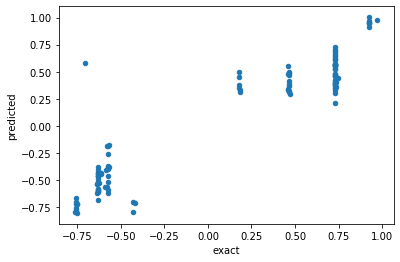

In [446]:
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)
print(my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)
[0])

#print(predicted[:])
df_compare=pd.DataFrame({"predicted":predicted, "exact":exact})

#for i in range(100):
#    print(predicted[i][0],exact[i],predicted[i][0]-exact[i])
    
df_compare.plot.scatter(x="exact", y="predicted")
df_compare.to_csv("first_test.csv")
df_compare.head(50)


0.0218 for first try

min error at around 10k-12k epochs
-> 0,03


[10,10,5]_12000 => 0,176
[10,10]_12000 => 0,028


In [408]:
df_compare.head(50)
df_compare.to_csv("first_test.csv")

In [396]:
tf.test.is_gpu_available()


False

In [397]:
tf.config.list_physical_devices('GPU')

[]

In [399]:

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0
